In [1012]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

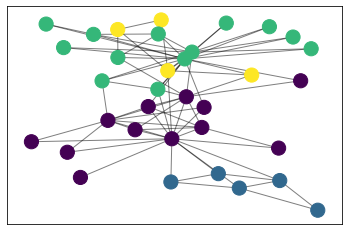

In [1013]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
# gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [1014]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))
gatewayGraph=nx.Graph()
gatewayGraph.add_edges_from(gateEdges)

Gateway graph nodes: [5, 1, 6, 7, 9, 3, 11, 26, 24, 28, 25, 29, 31, 2, 32, 33, 34, 10, 14, 20]


In [1015]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
tot_graphs=[]
for i in range(0,500):
    g = G
    gatew = gatewayGraph
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in G.edges()}
    nx.set_edge_attributes(g, attr)
    tot_g.append(g.subgraph(gatew))
    tot_graphs.append(g)
# for k in range(0,500):
#     print(len(tot_g[k]))
#     tot_g[k].add_nodes_from(gateNodesList)
#     print(len(tot_g[k]))
#     for i in range(0,len(gateEdges)):
#         tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))
#     break

In [1016]:
#BCS Score
def BCS(gg,nodes,nodeList):
    BCS_={}
    for node in nodeList:
        BCS_[node]=0
    for i in gg:
        x=(nx.betweenness_centrality(i,weight='weight'))
        for j in x:
            BCS_[j]+=(1/500)*x[j]
    return BCS_
BCS_value=BCS(tot_g,len(gateNodesList),gateNodesList)
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 0.4736842105263191), (3, 0.33918128654970475), (34, 0.22076023391813135), (5, 0.1988304093567259), (32, 0.1812865497076017), (14, 0.1154970760233932), (11, 0.10526315789473817), (28, 0.08187134502923908), (2, 0.06432748538011722), (25, 0.03508771929824559), (6, 0.0), (7, 0.0), (9, 0.0), (26, 0.0), (24, 0.0), (29, 0.0), (31, 0.0), (33, 0.0), (10, 0.0), (20, 0.0)]


In [1017]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 2631.72it/s]


In [1018]:
print(time_of_diffusion)

{1: 48, 2: 53, 3: 47, 4: 56, 5: 67, 6: 57, 7: 49, 8: 55, 9: 48, 10: 53, 11: 74, 12: 71, 13: 86, 14: 50, 15: 34, 16: 0, 17: 62, 18: 84, 19: 33, 20: 40, 21: 40, 22: 55, 23: 31, 24: 50, 25: 100, 26: 58, 27: 63, 28: 58, 29: 42, 30: 58, 31: 37, 32: 46, 33: 22, 34: 30}


In [1019]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[1, 3, 34]
[5, 1, 6, 7, 9, 3, 11, 26, 24, 28, 25, 29, 31, 2, 32, 33, 34, 10, 14, 20]
46


In [1020]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[18, 17]


In [1021]:
timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

100%|██████████| 200/200 [00:00<00:00, 2468.76it/s]

46



 91%|█████████ | 182/200 [00:00<00:00, 1819.82it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


100%|██████████| 200/200 [00:00<00:00, 2222.71it/s]

46



  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2174.26it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2298.40it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2272.30it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2150.20it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2127.23it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2272.86it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2221.77it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2439.60it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2325.69it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2409.83it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2105.28it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2247.40it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2352.47it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2325.31it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2083.28it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2381.19it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2222.45it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2083.63it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 1980.35it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2299.05it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2272.84it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


 91%|█████████ | 182/200 [00:00<00:00, 1819.88it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2247.72it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


 90%|█████████ | 181/200 [00:00<00:00, 1792.33it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2127.31it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


 94%|█████████▍| 189/200 [00:00<00:00, 1871.33it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


 77%|███████▋  | 154/200 [00:00<00:00, 1524.91it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2020.24it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2380.53it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2298.46it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2020.32it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


 92%|█████████▏| 183/200 [00:00<00:00, 1812.07it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2150.62it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


 98%|█████████▊| 197/200 [00:00<00:00, 1951.08it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2150.59it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2247.05it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2325.29it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2082.93it/s]

46
46



100%|██████████| 200/200 [00:00<00:00, 2381.44it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2409.78it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2174.08it/s]

46
46



  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


  0%|          | 0/200 [00:00<?, ?it/s]

46
46


100%|██████████| 200/200 [00:00<00:00, 2083.48it/s]


In [1022]:
for i in timeOfDiffusions:
    print(i)
print(len(gateNodesList))

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
3

46


100%|██████████| 200/200 [00:00<00:00, 3636.22it/s]


100%|██████████| 200/200 [00:00<00:00, 3125.05it/s]


100%|██████████| 200/200 [00:00<00:00, 4166.80it/s]


[[5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 1.2195188035821674e-05, 5.233632458054444e-60, 5.233632458054444e-60, 4.619015946370681e-68, 5.233632458054444e-60, 6.227988071999836e-10], [5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 6.227988071999836e-10, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 4.389672906314681e-68, 5.233632458054444e-60, 3.203920289243778e-06, 5.233632458054444e-60, 5.527765729365557e-07, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60], [5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.23

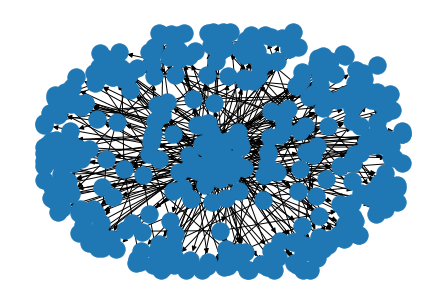

In [1023]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=[]
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 0.07)
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
#         print("WWWW ",time_of_diffusion[17])
        
#         print("--->> ",sensor_nodes)
#         print("***** ")
#         for s in sensor_nodes:
#             print(time_of_diffusion[s])
#         print("***** ")
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
#         print(len(delta_t),len(mu))
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion[sensor])
                
#         print("arrivals",arrivals)
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
#             print("new_delta_ts",new_delta_ts)
#         print(new_delta_ts)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
#             print("---> ",len(new_delta_ts[i]),len(new_delta_ts[i+1]))
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val)
#         print("lambd",lambd)
#         print("delta_t",delta_t,"mu",mu)    
        sub = np.subtract(delta_t,mu)
#         print("sub",sub)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
#         print("powerOfe",powerOfe)
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax.append(fun)
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [1024]:
print(allDiffusionTime)

[{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 29: 0, 6: -1, 7: -1, 9: -1, 11: -1, 26: -1, 24: -1, 28: -1, 25: -1, 31: -1, 32: -1, 33: -1, 34: -1, 10: -1, 14: -1, 20: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 26: 0, 24: -1, 28: -1, 25: -1, 29: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 33: 0, 24: 4, 26: -1, 28: -1, 25: -1, 29: -1, 31: -1, 32: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: 0, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 26: -1, 24: -1, 28: -1, 25: -1, 29: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 33: 0, 24: 93, 

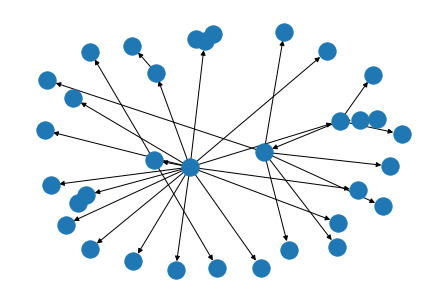

In [1025]:
nx.draw(nx.bfs_tree(g, source = 1))

In [1026]:
print(len(toTakeArgmax[0]),len(toTakeArgmax))

20 20


In [1027]:
finArg = np.argmax(toTakeArgmax,axis=1)

In [1028]:
id=-1
mx=-1
for i in range(0,len(finArg)):
    if(toTakeArgmax[i][finArg[i]]>mx):
        mx=toTakeArgmax[i][finArg[i]]
        id=i
clusterNode=gateNodesList[id]

In [1029]:
print(clusterNode)

33


In [1030]:
partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])

2


In [1048]:
print(partition[16])

2


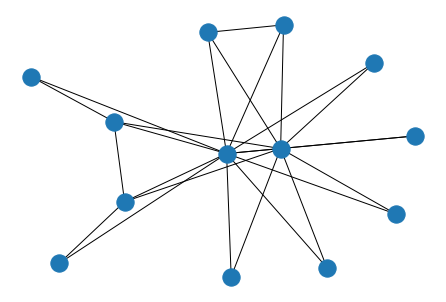

In [1032]:
candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

In [1033]:
myset=set([])
for e in candidateCluster:
    myset.add(e[0])
    myset.add(e[1])
print(myset)
my=[]
for ele in myset:
    my.append(ele)
print("list",my)


{33, 34, 9, 15, 16, 19, 21, 23, 24, 27, 28, 30, 31}
list [33, 34, 9, 15, 16, 19, 21, 23, 24, 27, 28, 30, 31]


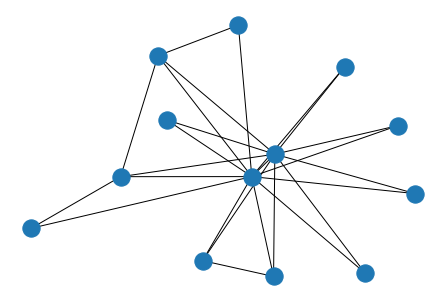

In [1034]:
cG = G.subgraph(my)
nx.draw(cG)

500


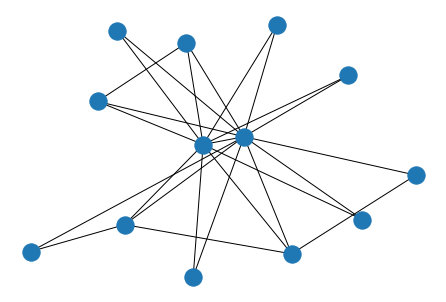

In [1035]:
tot_cg_set=set([])
for i in range(0,500):
    tot_cg_set.add(tot_graphs[i].subgraph(my))
print(len(tot_cg_set))
tot_cg=[]
for g in tot_cg_set:
    tot_cg.append(g)
# print(len(tot_cg))
nx.draw(tot_graphs[7].subgraph(my))

In [1036]:
print(len(cG.edges()))
nodes_in_cg=[]
nodes_in_cg_set=set([])
for ee in cG.edges():
    nodes_in_cg_set.add(ee[0])
    nodes_in_cg_set.add(ee[1])
for ele in nodes_in_cg_set:
    nodes_in_cg.append(ele)
print("nodes_in_cg",nodes_in_cg)
print(len(tot_cg[0]))
BCS_value_cg=BCS(tot_cg,len(tot_cg)+2,nodes_in_cg)
BCS_value_cg=(sorted(BCS_value_cg.items(), key=lambda x: x[1],reverse=True))

25
nodes_in_cg [33, 34, 9, 15, 16, 19, 21, 23, 24, 27, 28, 30, 31]
13


In [1037]:
# Model selection - diffusion time
model = ep.SIModel(cG)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in cG.edges()]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion_cg={}
for i in range(1,node+1):
    time_of_diffusion_cg[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion_cg[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 2778.01it/s]


In [1038]:
print(time_of_diffusion_cg)

{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: 33, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: 27, 16: 45, 17: -1, 18: -1, 19: 25, 20: -1, 27: 0, 34: 23, 23: 28, 24: 33, 33: 35, 31: 35, 30: 38, 21: 39, 28: 41}


In [1039]:
sensor_nodes_cg=[BCS_value_cg[i][0] for i in range(0,3)]
print(sensor_nodes_cg)

[34, 30, 33]


In [1040]:
delta_t_cg=[]
min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
min_n_cg=-1
for i in sensor_nodes_cg:
    if(time_of_diffusion_cg[i]==min_v_cg):
        min_n_cg=i
        break
delta_t_cg=[abs(time_of_diffusion_cg[i]-min_v_cg) for i in sensor_nodes_cg if(i!=min_n_cg)]
print(delta_t_cg)

[15, 12]


100%|██████████| 200/200 [00:00<00:00, 4877.95it/s]


100%|██████████| 200/200 [00:00<00:00, 6061.22it/s]


[[5.233632458054444e-60, 5.233632458054444e-60, 5.594606101578841e-07, 5.233632458054444e-60, 5.233632458054444e-60, 6.227988071999836e-10, 6.227988071999836e-10, 7.883657630422654e-72, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 6.227988071999836e-10, 5.233632458054444e-60, 5.233632458054444e-60, 6.227988071999836e-10, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60], [5.233632458054444e-60, 6.227988071999836e-10, 5.233632458054444e-60, 5.233632458054444e-60, 6.227988071999836e-10, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 4.389672906314681e-68, 5.233632458054444e-60, 6.227988071999836e-10, 4.389672906314681e-68, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 4.389672906314681e-68], [5.233632458054444e-60, 5.233632458054444e-60, 5.233632458054444e-60, 5.233

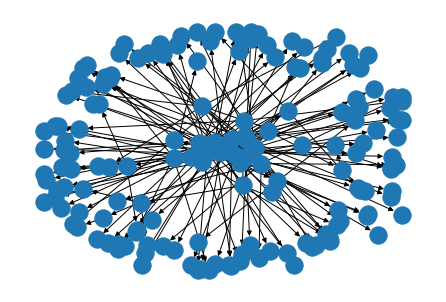

In [1041]:
g___cg = nx.Graph()
g___cg.add_edges_from(cG.edges())
# allDiffusionTime = []
mcaps_cg=[tot_cg[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax_cg=[]
for node in nodes_in_cg:
#     print(node)
    bfs_tree = nx.bfs_tree(g___cg, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax_cg=[]
    for mcap_cg in mcaps_cg:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion_cg={}
        for i in range(1,node+1):
            time_of_diffusion_cg[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_cg[j]=i['iteration']
        
        for node in nodes_in_cg:
            if node not in time_of_diffusion_cg.keys(): 
                time_of_diffusion_cg[node]=-1
        
        min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
        min_n_cg=-1
        for i in sensor_nodes_cg:
            if(time_of_diffusion_cg[i]==min_v_cg):
                min_n_cg=i
                break
        mu_cg=[abs(time_of_diffusion_cg[i]+min_v_cg)/2 for i in sensor_nodes_cg if(i!=min_n_cg)]
#         print(len(delta_t_cg),len(mu_cg))
        
        arrivals_cg=[]
        
        for sensor in sensor_nodes_cg:
            if(time_of_diffusion_cg[sensor]==-1):
                arrivals_cg.append(200)
            else:
                arrivals_cg.append(time_of_diffusion_cg[sensor])
                
#         print("arrivals_cg",arrivals_cg)
                
        new_delta_ts_cg = []
            
        for i in range(0,len(arrivals_cg)):
            new_delta_t_cg=[]
            for j in range(0,len(arrivals_cg)):
                if(i!=j):
                    new_delta_t_cg.append(abs(arrivals_cg[j]-arrivals_cg[i]))
            new_delta_ts_cg.append(new_delta_t_cg)
#             print("new_delta_ts_cg",new_delta_ts_cg)
#         print(new_delta_ts_cg)
            
        lambd_cg = []
        for i in range(0,len(new_delta_ts_cg)-1):
#             print("---> ",len(new_delta_ts_cg[i]),len(new_delta_ts_cg[i+1]))
            val_cg = np.correlate(new_delta_ts_cg[i],new_delta_ts_cg[i+1],"same")
            for i in range(0,len(val_cg)):
                if (val_cg[i]==0):
                    val_cg[i]=1
            lambd_cg.append(val_cg)
#         print("lambd_cg",lambd_cg)
#         print("delta_t_cg",delta_t_cg,"mu_cg",mu_cg)    
        sub_cg = np.subtract(delta_t,mu_cg)
#         print("sub_cg",sub_cg)
        lambd_cg[0][1]=0
        powerOfe_cg = np.dot(np.dot((sub_cg), np.linalg.inv(lambd_cg) ),np.transpose(sub_cg))
#         print("powerOfe_cg",powerOfe_cg)
        powerOfe_cg=abs(powerOfe_cg)
        fun_cg = (1/np.linalg.det(lambd_cg))*np.exp(-(1/2)*powerOfe_cg)
        vecOfArgmax_cg.append(fun_cg)
    toTakeArgmax_cg.append(vecOfArgmax_cg)
print(toTakeArgmax_cg)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [1042]:
print(len(toTakeArgmax_cg[0]),len(toTakeArgmax_cg))

20 13


In [1043]:
finArg_cg = np.argmax(toTakeArgmax_cg,axis=1)

In [1044]:
id_cg=-1
mx_cg=-1
for i in range(0,len(finArg_cg)):
    if(toTakeArgmax_cg[i][finArg_cg[i]]>mx):
        mx_cg=toTakeArgmax_cg[i][finArg_cg[i]]
        id_cg=i
source_node=nodes_in_cg[id_cg]
print(source_node)

31


In [1047]:
print(partition[source_node])
print(partition[16])

2
2


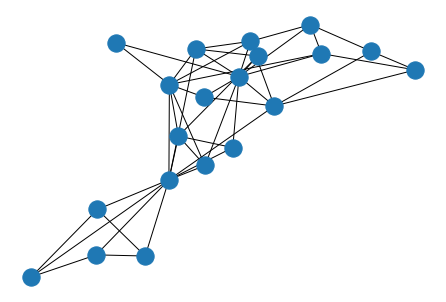

In [1046]:
nx.draw(G.subgraph(gatew))